# Tema 3: Entrega práctica - Estudio final preprocesado

### Autor: Juan José Méndez Torrero

### Asignatura: Procesamiento y Visualización de Datos

# Fuente de datos

El conjunto de datos para esta práctica contiene información sobre los datos recogidos de un experimento sobre la plantación de nubes en Tasmania entre 1964 y 1971. Este conjunto de datos se pueden encontrar en la base de datos de [OpenML](https://www.openml.org/d/210). Se ha elegido este dataset ya que cuenta con un número suficiente de instancias (108) y características (7). Estas características son:

- PERIOD: Valor numérico referente al periodo de extracción.
- SEEDED: Valor nominal representando si se ha plantado o no.
- TE: Valor numérico.
- TW: Valor numérico.
- NC: Valor numérico.
- SC: Valor numérico.
- NWC: Valor numérico.

Además, este conjunto de datos cuenta con una variable a predecir que es de tipo categórico. Puede tomar dos valores, "P" como positivo (sí se ha plantado), y "N" como negativo (no se ha plantado).

Este conjunto de datos nos permitirá aplicar las distintas técnicas de preprocesado vistas a lo largo del curso, ya que cuenta tanto con variables de tipo numérico, como de tipo categórico. Finalmente, también nos permitirá realizar un PCA sobre las caracterísitcas para seleccionar el componente principal que mejor explique los datos.

# Código de extracción de datos

Para la extracción del conjunto de datos elegido, se hará uso de la función predefinida de sklearn _fetch_openml_ para poder descargar nuestro conjunto de datos fácilmente. Hay que tener en cuenta que se ha usado la segunda versión del conjunto de datos elegido, ya que la variable de salida se ha convertido en binaria, mientras que en la primera versión del conjunto de datos, la variable a predecir era de tipo numérico. 

Finalmente, agruparemos todos los atributos con la variable de salida para su mejor estudio y procesamiento.

In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml
dataset = fetch_openml(name='cloud', version=2, as_frame=True)

data = pd.DataFrame(dataset.data, columns= dataset.feature_names)

target = pd.DataFrame(dataset.target, columns = dataset.target_names)

data["CLASS"] = target

data

,PERIOD,SEEDED,TE,TW,NC,SC,NWC,CLASS
0,1.0,seeded,1.69,3.73,1.65,1.80,3.33,N
1,2.0,unseeded,0.74,0.78,1.09,0.79,1.59,N
2,3.0,seeded,0.81,0.86,2.39,0.36,2.06,N
3,4.0,unseeded,1.44,2.01,2.96,1.27,4.05,N
4,5.0,seeded,2.48,4.61,4.16,2.16,6.00,N
...,...,...,...,...,...,...,...,...
103,190.0,unseeded,1.36,3.43,1.38,1.86,2.91,P
104,191.0,seeded,1.17,1.65,1.22,2.28,1.58,P
105,192.0,unseeded,2.37,1.94,2.46,2.47,2.39,P
106,193.0,seeded,0.02,0.08,0.05,0.02,0.09,P


# Análisis preliminar

Una vez hemos realizado los cambios sobre las características, separaremos las columnas numéricas y las columnas catégoricas para su posterior uso en el análisis del conjunto de datos.

In [2]:
def get_columns_types(data):
    numeric_columns = []
    nominal_columns = []

    for col in data.columns.values:
        
        if pd.api.types.is_numeric_dtype(data[col]):
            numeric_columns.append(col)

        else:
            nominal_columns.append(col)

    print("Las columnas numéricas son: {0}".format(str(numeric_columns)))
    print("Las columnas nominales son: {0}".format(str(nominal_columns)))

    return numeric_columns, nominal_columns

numeric_columns, nominal_columns = get_columns_types(data)

Las columnas numéricas son: ['PERIOD', 'TE', 'TW', 'NC', 'SC', 'NWC']
Las columnas nominales son: ['SEEDED', 'CLASS']


Podemos observar que todas las variables son de tipo numérico excepto para las características _SEEDED_ y la variable a predecir _CLASS_. A continuación se verá una descripción de las medidas básicas de las características. 

De esta descripción se puede observar que no existen valores perdidos para ninguna de las características. Además, también se puede observar que las características no están normalizadas, ya que el rango de valores no es [0,1]. Con lo que será necesaria una normalización para un mejor funcionamiento del proceso de aprendizaje.

In [3]:
data.describe()

,PERIOD,TE,TW,NC,SC,NWC
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,100.574074,1.232593,2.046389,1.506389,1.202130,2.192870
std,58.281175,1.077179,1.515722,1.431687,0.891783,1.632942
min,1.000000,0.000000,0.060000,0.000000,0.020000,0.040000
25%,55.750000,0.512500,0.890000,0.410000,0.535000,0.882500
50%,106.500000,0.910000,1.555000,1.285000,0.995000,1.915000
75%,133.250000,1.675000,3.000000,2.132500,1.662500,3.050000
max,194.000000,6.000000,6.930000,9.420000,4.020000,7.840000


De las siguientes figuras se puede observar que la característica _PERIOD_ toma valores discontinuos, mientras que el resto de variables presentan una distribución sesgada hacia la derecha, o también se puede decir que presentan un sesgo positivo.

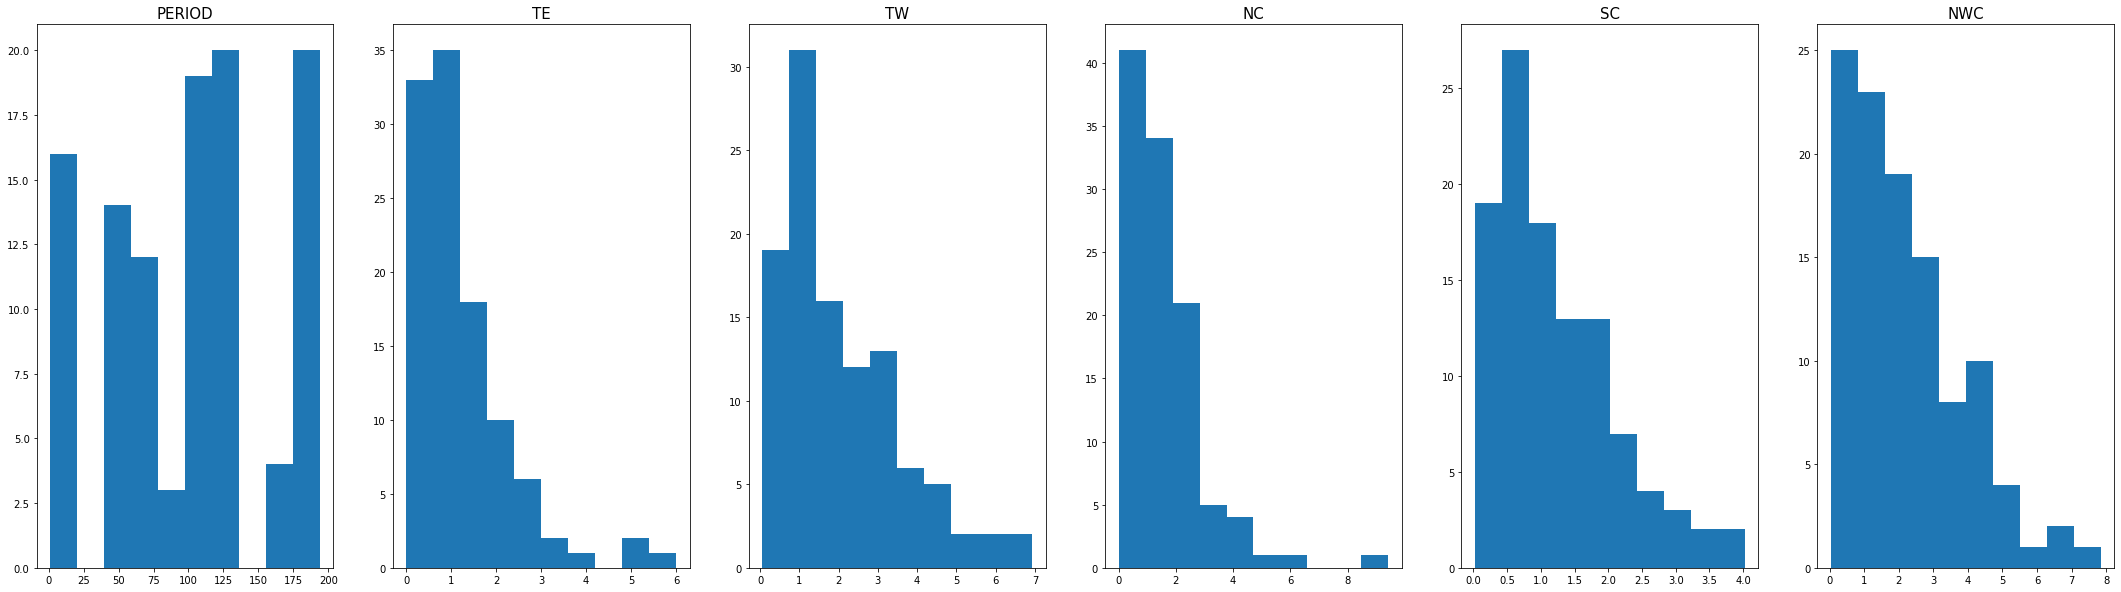

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (50,10))

i=1

for col in numeric_columns:
    ax = fig.add_subplot(1,len(data.columns), i)
    ax.set_title(col, fontsize = 15)
    ax.hist(data[col], bins=10)

    i += 1



De la siguiente matriz de correlaciones se pueden observar características que presentan una relación bastante fuerte, como pueden ser las caracterísicas _TE_ y _NC_ (0.83) o también, las características _TE_ y _SC_ (0.86). Por el contrario, también se puede observar una baja correlación entre la característica _PERIOD_ y el resto de características, con lo que esto nos puede indicar que la característica _PERIOD_ no tiene mucha influencia con el resto de características.

<AxesSubplot:>

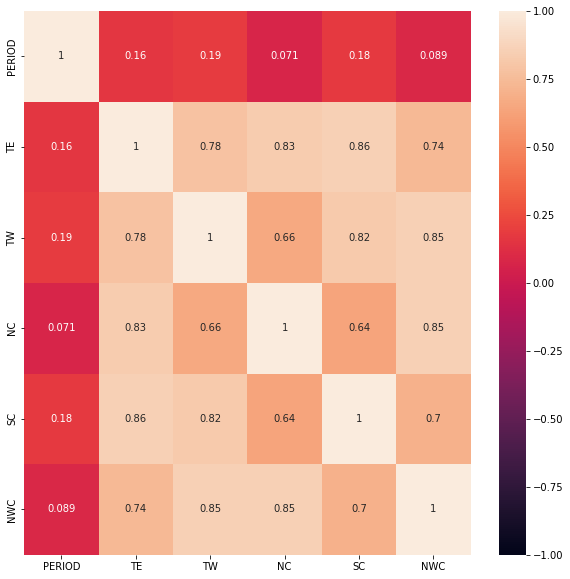

In [5]:
import seaborn as sns # pip install seaborn

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, ax=ax)

# Transformación de los datos

A continuación, se realizará el proceso de _one-hot encoding_ para poder usar los valores de las columnas categóricas. Para ello, haremos uso de la función predefinida de pandas _get_dummies_, que nos permitirá crear un one-hot encoding para la columna categórica que existe en el conjunto de datos. Para ello, primero debemos descartar la característica predictora para que no se le aplique el proceso de _one-hot encoding_.

Como se puede observar, se ha creado una nueva columna por cada posible valor que hubiera dentro de la columna _SEEDED_ (única variable categórica). Este proceso de transformación de los datos nos permitirá a nuestro modelo realizar un proceso de aprendizaje más fácil que si fuera una característica nominal.

In [6]:
class_df = data["CLASS"]

data = data.drop(["CLASS"], axis=1)

enc_data = pd.get_dummies(data) # One-hot encoding

enc_data["CLASS"] = class_df

enc_data

,PERIOD,TE,TW,NC,SC,NWC,SEEDED_seeded,SEEDED_unseeded,CLASS
0,1.0,1.69,3.73,1.65,1.80,3.33,1,0,N
1,2.0,0.74,0.78,1.09,0.79,1.59,0,1,N
2,3.0,0.81,0.86,2.39,0.36,2.06,1,0,N
3,4.0,1.44,2.01,2.96,1.27,4.05,0,1,N
4,5.0,2.48,4.61,4.16,2.16,6.00,1,0,N
...,...,...,...,...,...,...,...,...,...
103,190.0,1.36,3.43,1.38,1.86,2.91,0,1,P
104,191.0,1.17,1.65,1.22,2.28,1.58,1,0,P
105,192.0,2.37,1.94,2.46,2.47,2.39,0,1,P
106,193.0,0.02,0.08,0.05,0.02,0.09,1,0,P


Ahora es turno de las variables numéricas. Como hemos podido observar, ninguna de las características numéricas presenta una distribución normal, con lo que, para que nuestro modelo consiga aprender más fácilmente las características, vamos a realizar un proceso de normalización, que consiste transformar las características a un rango entre [0,1]. Para ello, haremos uso de la función predefinida MinMaxScaler, el cual nos permite seleccionar el rango en el que queremos que se encuentren las características.

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

enc_data[numeric_columns] = pd.DataFrame(scaler.fit_transform(enc_data[numeric_columns]), columns=numeric_columns)

Como se puede observar en la siguiente tabla, las caracterísicas ahora se encuentran normalizadas entre 0 y 1, con lo que a nuestro modelo, le será más fácil poder diferencias entre una clase u otra.

In [8]:
enc_data.describe()

,PERIOD,TE,TW,NC,SC,NWC,SEEDED_seeded,SEEDED_unseeded
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,0.515928,0.205432,0.289140,0.159914,0.295532,0.276009,0.500000,0.500000
std,0.301975,0.179530,0.220629,0.151984,0.222946,0.209352,0.502331,0.502331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.283679,0.085417,0.120815,0.043524,0.128750,0.108013,0.000000,0.000000
50%,0.546632,0.151667,0.217613,0.136412,0.243750,0.240385,0.500000,0.500000
75%,0.685233,0.279167,0.427948,0.226380,0.410625,0.385897,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Selección de características
En esta sección se realizará el proceso PCA (Principal Component Analysis) para realizar una selección de un conjunto de características para que retenga gran parte de la información del resto de características.

In [9]:
from sklearn import decomposition

y = pd.DataFrame(enc_data["CLASS"], columns=["CLASS"])

enc_data = enc_data.drop(["CLASS"], axis=1)

pca = decomposition.PCA(n_components=2)

enc_data_pca = pca.fit_transform(enc_data)

In [10]:
data_pca_df = pd.DataFrame(enc_data_pca, columns=["PC1", "PC2"])

data_pca_df.head()

,PC1,PC2
0,-0.689884,0.210854
1,0.690274,-0.395464
2,-0.715831,-0.278639
3,0.719828,0.001589
4,-0.658297,0.608565


In [17]:
print("La varianza explicada entre los dos componentes es de: " + str(round((pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]) * 100, 2)) + "%")

La varianza explicada entre los dos componentes es de: 84.84%


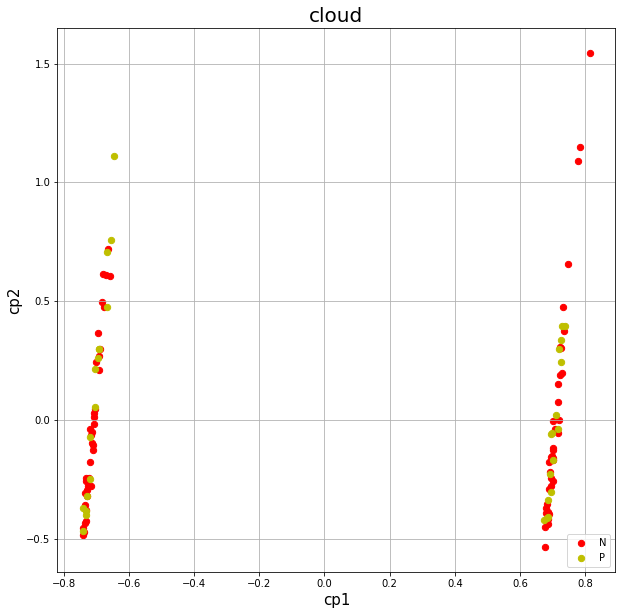

In [11]:
from matplotlib import pyplot
import numpy as np

fig = pyplot.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('cp1', fontsize = 15)
ax.set_ylabel('cp2', fontsize = 15)
ax.set_title('cloud', fontsize = 20)
objetivos = ["N", "P"]
colores = ['r', 'y', 'b']
for obj, c in zip(objetivos, colores):
    seleccionados = np.array(y == obj)[:,0]
    ax.scatter(enc_data_pca[seleccionados, 0], enc_data_pca[seleccionados, 1], s=40, color= c)
ax.legend(objetivos, loc="lower right")
ax.grid()

Como conclusión, podemos observar que la varianza explicada entre los dos componentes es batante alta (84,84%). Aún así, también se puede observar que estos dos componentes no realizan una correcta división de los datos. Esto puede ser debido a que la reducción de características en un problema de este tipo (bajo número de características), puede que no realice una correcta división, ya que estamos perdiendo información de otras características que pudieran hacer una mejor división de los datos.